In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from qiskit import IBMQ, execute
import qiskit.tools.jupyter
from qiskit import pulse
from qiskit.pulse import pulse_lib

In [3]:
IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
provider = IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
cmd_def = pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
config = backend.configuration()

In [5]:
anh_almaden = [-320.2, -319.7, -317.2, -320.6, -322.0, -322.5,
               -269.1, -297.1, -320.4, -325.0, -318.7, -319.5,
               -321.1, -319.8, -322.7, -325.5, -320.9, -321.3,
               -321.6, -323.0]

In [6]:
anh = anh_almaden

In [7]:
backend

<IBMQBackend('alt_almaden') from IBMQ(hub='ibm-q-dev', group='qiskit-terra', project='pulse-testing')>

------------

In [8]:
MEASUREMENT_START_TIMESTEP = 500

In [9]:
# just measure
schedule0 = pulse.Schedule()
schedule0 |= measure << MEASUREMENT_START_TIMESTEP

In [10]:
# X, then measure
schedule1 = pulse.Schedule()
schedule1 |= cmd_def.get('x', qubits=[0])
schedule1 |= measure << MEASUREMENT_START_TIMESTEP

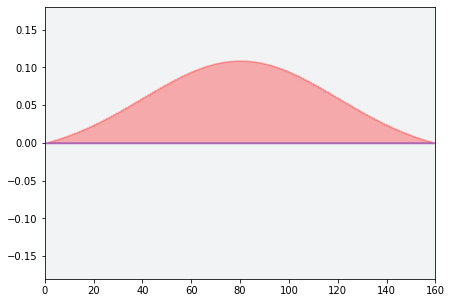

In [11]:
# Approximate X as a gaussian pulse:
DURATION = 160
AMP = 0.109
SIGMA = 40

my_x = pulse_lib.gaussian(duration=DURATION, amp=AMP, sigma=SIGMA)
my_x.draw(scaling=0.18)

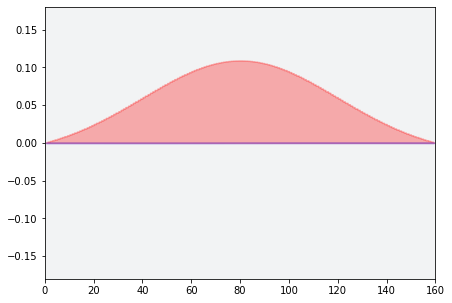

In [12]:
device_x = cmd_def.get('x', qubits=[0]).instructions[0][1].command
device_x.draw(scaling=0.18)

In [13]:
# X, then pulse at 1-2 frequency, then measure
schedule2 = pulse.Schedule()
schedule2 |= cmd_def.get('x', qubits=[0])

freq = config.dt * anh[0] * 1e6 * -1 # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns
wave_samples = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
            duration=DURATION, amp=1, freq=freq).samples
# use amplitude of AMP / sqrt(2) for 1->2 transition
gaussian_samples = pulse.pulse_lib.gaussian(duration=DURATION, amp=AMP / np.sqrt(2), sigma=SIGMA).samples
schedule2 |= pulse.SamplePulse(gaussian_samples * wave_samples)(config.drive(0)) << schedule2.duration

schedule2 |= measure << MEASUREMENT_START_TIMESTEP

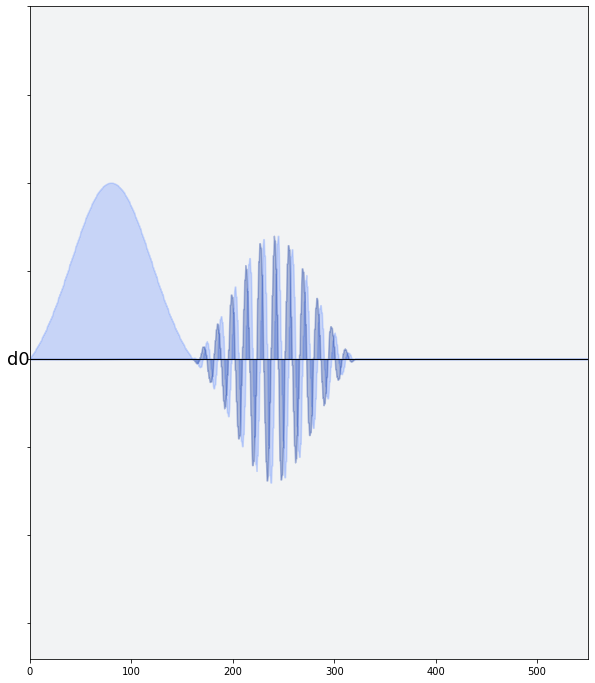

In [14]:
schedule2.draw(plot_range=[0, 550], channels_to_plot=[config.drive(0)])

In [23]:
job = execute([schedule0, schedule1, schedule2], backend=backend, shots=1000, meas_level=1, meas_return='single')

In [52]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [27]:
backend.status()

BackendStatus(backend_name='alt_almaden', backend_version='1.2.4', operational=True, pending_jobs=1, status_msg='active')

In [ ]:
# try different amplitudes for the 2-3 frequency

In [29]:
# X, then pulse at 1-2 frequency, then pulse at 2-3 frequency, then measure
freq = config.dt * anh[0] * 1e6 * -1 # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns

schedules3 = []
amp_factors = np.arange(0.3, 1, 0.05)
for factor in amp_factors:
    schedule3 = pulse.Schedule()
    schedule3 |= cmd_def.get('x', qubits=[0])
    # use qubit_freq - anharmonicity and amplitude of AMP / sqrt(2) for 1->2 transition
    wave_samples_1 = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
                duration=DURATION, amp=1, freq=freq).samples
    gaussian_samples_1 = pulse.pulse_lib.gaussian(duration=DURATION, amp=AMP / np.sqrt(2), sigma=SIGMA).samples
    schedule3 |= pulse.SamplePulse(gaussian_samples_1 * wave_samples_1)(config.drive(0)) << schedule3.duration

    # use qubit_freq - 2 x anharmonicity and amplitude of AMP / x for 1->2 transition (0.3<x<1)
    wave_samples_2 = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=2*freq).samples - 1j * pulse.pulse_lib.sin(
                duration=DURATION, amp=1, freq=2*freq).samples

    gaussian_samples_2 = pulse.pulse_lib.gaussian(duration=DURATION, amp=AMP * factor, sigma=SIGMA).samples
    schedule3 |= pulse.SamplePulse(gaussian_samples_2 * wave_samples_2)(config.drive(0)) << schedule3.duration

    schedule3 |= measure << MEASUREMENT_START_TIMESTEP
    schedules3.append(schedule3)

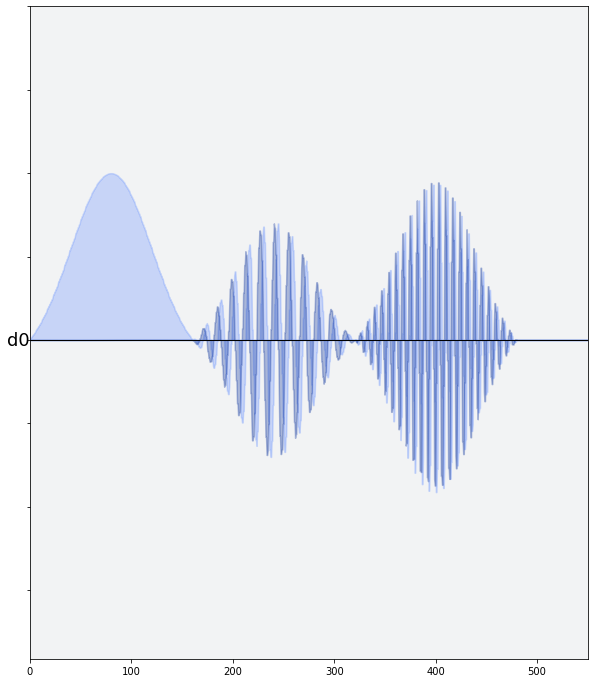

In [39]:
sched = schedules3[13]
sched.draw(plot_range=[0, 550], channels_to_plot=[config.drive(0)])

In [41]:
job3 = execute(schedules3, backend=backend, shots=1000, meas_level=1, meas_return='single')

In [62]:
job3.status()

<JobStatus.DONE: 'job has successfully run'>

In [60]:
backend.status()

BackendStatus(backend_name='alt_almaden', backend_version='1.2.4', operational=True, pending_jobs=3, status_msg='active')

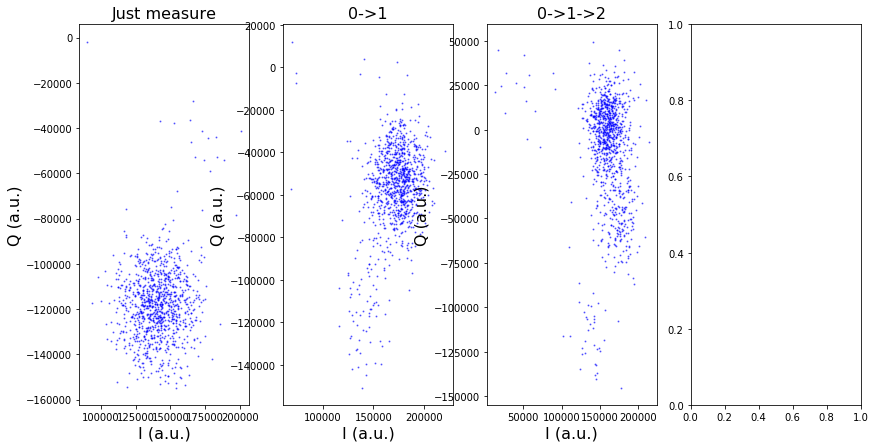

In [53]:
%matplotlib inline
fig, axes = plt.subplots(1, 4)
i = 0
fig.set_size_inches(14,7)

titles = ['Just measure', '0->1', '0->1->2']
result = job.result()

for (i, title) in enumerate(titles):
    memory_shots = result.get_memory(i)
    qubit_0_readouts = [memory_shot[0] for memory_shot in memory_shots]

    ax = axes[i]
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('I (a.u.)', fontsize=16)
    ax.set_ylabel('Q (a.u.)', fontsize=16)
    ax.scatter(np.real(qubit_0_readouts) * 1e-10, np.imag(qubit_0_readouts) * 1e-10,
               s=1, cmap='viridis',c='blue',alpha=0.5)
    i += 1

In [63]:
result3 = job3.result()

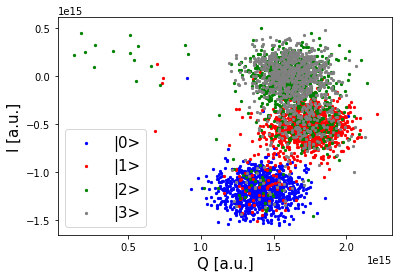

In [71]:
readouts_0 = [shot[0] for shot in result.get_memory(0)]
readouts_1 = [shot[0] for shot in result.get_memory(1)]
readouts_2 = [shot[0] for shot in result.get_memory(2)]
readouts_3 = [shot[0] for shot in result3.get_memory(0)]

plt.scatter(np.real(readouts_0), np.imag(readouts_0), 
            s=5, cmap='viridis', c='blue',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(readouts_1), np.imag(readouts_1), 
            s=5, cmap='viridis', c='red',alpha=1.0, label='state_1_mean')
plt.scatter(np.real(readouts_2), np.imag(readouts_2), 
            s=5, cmap='viridis', c='green',alpha=1.0, label='state_2_mean')
plt.scatter(np.real(readouts_3), np.imag(readouts_3), 
            s=5, cmap='viridis', c='grey',alpha=1.0, label='state_3_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.legend(["|0>","|1>","|2>","|3>"],fontsize=15)
plt.show()
plt.show()

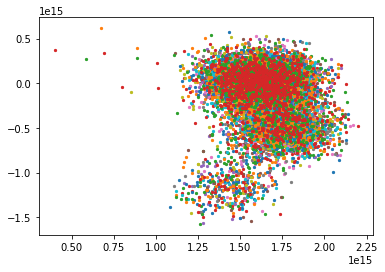

In [73]:
for i in range(len(amp_factors)):
    readouts_3 = [shot[0] for shot in result3.get_memory(i)]
    plt.scatter(np.real(readouts_3), np.imag(readouts_3), 
                s=5, cmap='viridis', alpha=1.0, label='state_3_mean')
plt.show()

|2> -> |3> is not working. the above experiments are trying to drive this with freq = Qubit_Freq - 2 x Anharmonicity, but sweeping different amplitudes for the Gaussian. The different amplitudes seem to not make a difference.